v 0.0.2

# Docket ML Jr CNH Challenge

Este notebook têm a função de demonstrar o resultado alcançado referente a tarefa proposta.

## Problemática

O teste consiste em extrair informações de uma CNH-(Carteira Nacional de Habilitação) através de processamento de imagem e/ou processamento de texto.

O requisito mínimo consiste em extrair apenas o campo CPF, assim a extração dos demais campos como (RG, Nome, etc..) se torna opcional.


## Planejamento

Foi utilizada a plataforma [Trello](https://trello.com/b/lbM5Opow/ds-workflow), aqui o processo é dividido em algumas etapas, o card transita de acordo com o que está sendo realizado no momento, não é necessariamente um processo linear, já que pode haver revisão das etapas e eventuais mudanças.
No trello esse processo é visualizado de uma forma Macro, não contendo detalhes e/ou especificidades de cada etapa, isso acaba sendo elaborado em papel mesmo e se for necessário transcrita na forma de relatório.

### Solução proposta

A princípio a idéia seria utilizar um algorítimo de OCR para extrair a informação na forma de texto do documento, para facilitar esse processo eu decidi destacar regiôes de interesse no documento com o intuito de diminuir possíveis erros do algorítimo de OCR. Assim treinei um modelo pela API de detecção de objetos do Tensorflow, para que fosse retornado essas áreas de interesse no formato de bounding boxes,e em cada área eu aplicaria o algorítimo de OCR.
Para treinar o modelo que detecta as regiões de interesse, realizei o transfer learning de uma rede neural SSD ResNet50 V1 FPN 640x640 (RetinaNet50) pré-treinada no conjunto de dados COCO 2017

### Dataset ROI (Region of Interest)

O dataset para gerar essas regiões de interesse é composto por 124 imagens de CNH, sendo elas reais ou modelos de material de divulgação, tendo variações no modelo(recentes e mais antigos), e também de resoluções diferentes.

Esse dataset foi obtido através de pesquisa no google images, estando estas sujeitas a copyrights, todas as imagens foram anotadas manualmente com a ajuda do software labelimg, que a API de Object Detection do Tensorflow recomenda, esse programa permita criar regiões de interesse para uma determinada classe, e os arquivos podem ser salvo no padrão YOLO (txt), e também em PascalVoc (xml).

![LabelImg](imgs/label_img.png)
    *Imagem do programa LabelImg utilizado*

### Resultado modelo ROI

In [1]:
import tensorflow as tf
import time
import glob
import numpy as np
import cv2 as cv
import pytesseract as ocr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
PATH_TO_SAVED_MODEL="../exported-models/my_model/saved_model"
print('Loading model...', end='')
# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

tesseract_config = r'-l por --oem 3'

Loading model...Done!


In [2]:
images = glob.glob("../images/test/*.jpg")

category_index = label_map_util.create_category_index_from_labelmap("../annotations/label_map.pbtxt",
                                                                    use_display_name=True)

Running inference for ../images/test/98.jpg... Done


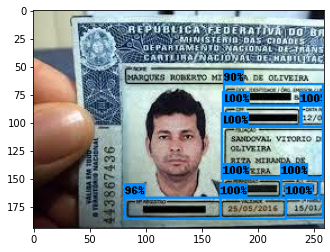

Running inference for ../images/test/27.jpg... Done


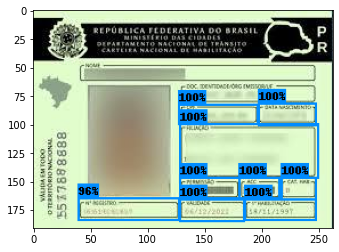

Running inference for ../images/test/142.jpg... Done


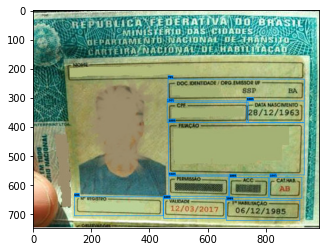

Running inference for ../images/test/47.jpg... Done


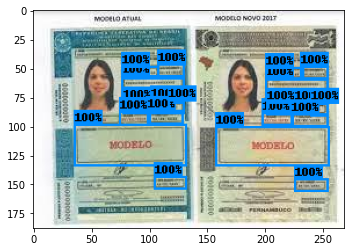

In [3]:
for img in images[:4]:
    print('Running inference for {}... '.format(img), end='')
    image = cv.imread(img)
    input_tensor=tf.convert_to_tensor(image)
    input_tensor=input_tensor[tf.newaxis, ...]

    detections=detect_fn(input_tensor)
    num_detections=int(detections.pop('num_detections'))
    detections={key:value[0,:num_detections].numpy() for key,value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections=image.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes'],
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=20,     
            min_score_thresh=0.5,
            line_thickness=2,    
            agnostic_mode=True)
    

    %matplotlib inline
    plt.figure()
    plt.imshow(image_np_with_detections[...,::-1])
    print('Done')
    plt.show()

Uma observação realizada após ver os resultados, é que o campo NOME & RG, não são detectados em todas as imagens, analisando o score para as bounding boxes consegui notar que o do campo nome é inferior ao treshold mínimo (50%), ficando entre 20% e 30%, isso pode se dar por diversos motivos, alguns eu consigo listar abaixo:
    - Poucos dados para treino, a proporção dos campos parecidos para o campo NOME & RG é de aproximadamente 7:1, então eu tenho 7 exemplos de campos menores para cada 1 campo NOME e isso pode levar ao modelo não aprender corretamente no mesmo tempo, isso poderia ser resolvido aumentando o tempo de treinamento ou diminuindo a diferença nessa proporção de exemplos deixando de anotar alguns campos.
    - Poderia ser pelo fato do campo ser igual na altura porém muito diferente no comprimento e o modelo acaba se confundindo, já que todos pertencem a mesma classe, isso resolveria trocando a anotação e atribuindo uma classe específica ao campo NOME & RG
    
Lembrando que isso são especulações do que poderia estar errado, nenhum dos pontos acima foi explorado, já que envolvem um campo que não é obrigatório aos requisitos do desafio, tempo disponível para re-treinar e re-anotar o conjunto de dados, e também há ha possibilidade de filtrar o score das bounding boxes, diminuindo o treshold e organizando elas em ordem de decrescente.

### Modelo OCR

Para o algorítimo de OCR, estou utilizando uma engine open-source chamada tesseract, em sua versão 4.0. Essa engine já contém modelos treinado para a língua portuguesa. A idéia aqui é submeter os campos ao modelo de OCR, processar a saída de texto, realizando a limpeza de caracteres indesejados para obter o valor de um campo específico.

In [5]:
def preprocessing_ocr(img):
    width, height = img.shape[:2]
    multiplier = round(600 / width)
#     result = cv2.medianBlur(img,5)
    result = cv.resize(img, None, fx=multiplier, fy=multiplier, interpolation=cv.INTER_CUBIC)
    result = cv.cvtColor(result, cv.COLOR_BGR2GRAY)
    result = cv.GaussianBlur(result,(5,5),0)
    _,result = cv.threshold(result,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
#     result = cv2.adaptiveThreshold(result,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    kernel = np.ones((2,2), np.uint8)
    result = cv.dilate(result, kernel, iterations =1)
#     result = cv2.erode(result,kernel,iterations = 1)
    
    return result

def crop_roi(img):
    input_tensor=tf.convert_to_tensor(img)
    input_tensor=input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections={key:value[0,:num_detections].numpy() for key,value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    crops = []
    height, width = img.shape[:2]
    for i in range(detections['detection_boxes'].shape[0]):
      if detections['detection_scores'][i] > 0.2:
        box = tuple(detections['detection_boxes'][i].tolist())
        ymin, xmin, ymax, xmax = box
        ymin = round(ymin * height)
        ymax = round(ymax * height)
        xmin = round(xmin * width)
        xmax = round(xmax * width)
        crops.append(img[ymin:ymax, xmin:xmax])
        
    return crops


In [ ]:
img = cv.imread('../images/test/95.jpg')

roi_list = crop_roi(img)

Podemos visualizar as regiões de interesse obtidas em um exemplo do conjunto de dados de teste.

In [ ]:
for roi in roi_list:
    plt.imshow(roi[...,::-1])
    plt.show()

Apesar da engine de OCR já conter um preprocessamento interno, é recomendado que haja um preprocessamento externo, para que o modelo de OCR tenha uma performance melhor, isso eu realizo utilizando a biblioteca OpenCV, as etapas de preprocessamento são:

    - redimensionamento
    - conversão para escala de cinza
    - remoção de ruídos
    - binarização
    - dilatação

In [ ]:
roi_preprocessed = [preprocessing_ocr(roi) for roi in roi_list]

for roi in roi_preprocessed:
    
    plt.imshow(roi, cmap='gray')
    plt.show()

### Avaliação OCR

In [ ]:
def find_cpf(ocr_text_list):
    cpf_regex = re.compile('\d{3}\.\d{3}\.\d{3}\-\d{2}')
    for text in ocr_text_list:
        result = re.findall(cpf_regex, text.replace(' ',''))
        if result:
            return result[0]
    return None

In [ ]:
cpf_images = glob.glob('../images/cpf/*.jpg')

In [ ]:
evaluation_cpf = {'image_name': [], 'ocr_cpf': [], 'width': [], 'height': []}
for image in tqdm(cpf_images):
    img_name = os.path.basename(image).split('.')[0]
    img = cv.imread(image)
    width, height = img.shape[:2]
    roi_list = crop_roi(img)
    roi_preprocessed = [preprocessing_ocr(roi) for roi in roi_list]
    text_list = [ocr.image_to_string(roi, config=tesseract_config) for roi in roi_preprocessed]
    ocr_cpf = find_cpf(text_list)
    
    evaluation_cpf['image_name'].append(img_name)
    evaluation_cpf['ocr_cpf'].append(ocr_cpf)
    evaluation_cpf['width'].append(width)
    evaluation_cpf['height'].append(height)

In [ ]:
cpf_df = pd.DataFrame(evaluation_cpf)

In [ ]:
target_df = pd.read_csv('../images/cpf/GT_CPF.csv')
target_df['image_name'] = target_df['image_name'].astype(str)

In [ ]:
cpf_df = cpf_df.merge(target_df, on='image_name')

In [ ]:
cpf_df["CPF"].replace('None', np.nan, inplace=True)
cpf_df['ocr_cpf'].fillna(np.nan, inplace=True)
cpf_df.fillna('0', inplace=True)

In [ ]:
cpf_df['result'] = cpf_df['ocr_cpf'] == cpf_df['CPF']

In [ ]:
accuracy = (cpf_df['result'].sum() / cpf_df.shape[0]) * 100

In [ ]:
accuracy

De todas as imagens no meu conjunto de dados, separei as que continham o campo cpf válido ou seja não estavam com alguma obstrução, nesses exemplos continham cpfs ineligíveis ao olho humano, a resolução era tão baixa que não era possível ler mesmo com aplicação de zoom.

A acurácia geral do sistema ficou em 52.94%, em um total de 34 exemplos.

O número não é muito expressivo, mas em um futuro estudo poderíamos abranger as causas desse resultado em alguns tipos de erro:

    - o cpf é legível, porém o ocr não retornou nenhum resultado
    - o cpf é legível, o ocr trouxe um resultado mas ele se difere do padrão xxx.xxx.xxx-xx, e assim na processo de filtrar o texto pelo filtro ser simples demais ele não trás nenhum resultado.
    - o cpf é legível, o ocr traz um resultado no formato correto, mas ele ele não detecta corretamente todos  os números, podendo interpretar 1 ou + de forma diferente.
    - o cpf é legível porem a imagem não têm resolução suficiente, ou se encontra em uma orientação diferente.

# Conclusão

Gostei muito do desafio, apesar do resultado ser menos expressivo do que o planejado, mas consegui ter conceitos iniciais sobre bastante coisa, principalmente na etapa do ocr e preprocessamento.

A idéia em usar esse conjunto ROI + OCR, se deu basicamente porque acredito ser mais fácil processar pequenas áreas da imagem do que ela como um todo, tive resultados melhores ao fazê-lo, ao mesmo tempo que minha expectativa era de que uma vez conseguido a região de interesse, o ocr seria bem mais fácil, porém toda a etapa de preprocessamento de imagem antes de aplicar o ocr acabou complicando as coisas, e é extremamente necessária.

Acabei não desenvolvendo muito o processamento de texto, realizei um regex muito simples para achar o CPF, mas complicações como o ocr não ler exatamente naquele formato, ignorando algun caracter especial igual o ponto (.) ou traço(-), o que é bastante comum, implica em uma limpeza melhor do texto, principalmente se fossemos aplicar isso aos outros campos como NOME etc, que não têm um padrão tão definido igual o CPF.
Um jeito de minimizar isso seria definindo classes específicas para identificar regiões de interesse, mas para isso o conjunto de dados precisaria ser muito maior.

Criar o conjunto de dados não foi difícil do ponto de vista técnico, mas foi muito trabalhoso, pesquisar imagens diferentes e anotar todos as regiões de interesse leva um tempo. Pelo fato que o teste deveria ser completado em 48h tentei não perder tanto tempo nessa etapa apesar dela ter a maior importância quando se trata de modelagem em ML, quanto mais tempos passamos melhorando a qualidade dos dados, menos tempo tentando ajustar parâmetros do modelo etc..

## Futuras melhorias

Além de a análise e atuação em todos os possíveis erros já citados anteriormente, durante minha pesquisa acabei me esbarrando em uma arquitetura de redes neurais diferente das que conhecia que ajuda bastante na solução de problema, são redes neurais com grafos em sua entrada. Isso é bem comentado nesse [artigo](https://nanonets.com/blog/id-card-digitization-deep-learning/#graph-neural-networks-and-digitization)